In [169]:
import os
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

import itertools
from collections import Counter
from nltk.corpus import stopwords
from pymystem3 import Mystem
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## Получение данных

In [2]:
# считываем данные с сохраненных веб-страниц

def reading_group(html, label):

    with open(html) as f:
        page = f.read()

    author, date, text = [], [], []

    comments = re.findall(r'<div class="bp_post clear_fix "((.|\n)*?)Показать список оценивших', page)
    for comment in comments:
        comment = comment[0]
        author.append(re.search(r'<a class="bp_author"(.*)">(.*)</a>', comment)[2])
        date.append(re.search(r'<a class="bp_date"(.*)">(.*)</a>', comment)[2])
        try:
            text.append(re.search(r'<div class="bp_text">(.*)</div>', comment)[1])
        except:
            text.append('')

    t_c, h_c, p_c = [], [], []

    for comment in text:
        href = re.findall(r"^<a href(.*)mem_link(.*)(.*)</a>", comment)
        
        ret = 'return showPhoto' in comment
        p_c.append(ret)
        
        if href:        
            h_lst = []
            for n in href:
                href = re.findall(r'Board.mentionOver\(this\)">(.*)', n[1])
                h_lst.append(href)
            comment = "{}, {}".format(','.join(h_lst[0]), comment.split("</a>,")[1])
            h_c.append(h_lst[0])
        else:
            h_c.append("na")
        t_c.append(re.sub('<br><br>', '', re.sub('</?div(.*)>', '', comment)))

    comments = pd.DataFrame(list(zip(author, date, t_c, h_c, p_c)),
                            columns=['author', 'date', 'comment', 'mention', 'image'])
    
    if label:
        comments['is_fake'] = 0
    else:
        comments['is_fake'] = 1
    
    return comments

In [3]:
# создаем датафрейм с данными каждой из подпапок

def create_df(directory, label):
    df = pd.DataFrame()
    path = './html/' + directory
    for filename in os.listdir(path):
        if filename.endswith(".html"):
            comments = reading_group(path + '/' + filename, label)
            df = pd.concat([df, comments], sort=True, ignore_index=True)
        else:
            continue
    return df

**author** - the user that posted a comment<br>
**comment** - text of the review<br>
**date** - when a comment was created<br>
**image** - True (1) if photos are attached, false otherwise<br>
**mention** - True (1) if there is a mention at the start of the message of another user, false otherwise<br>
**is_fake** - target label, True (1) if a comment is fake, false otherwise

In [4]:
# подпапка с реальными отзывами

df_true = create_df('vk/true', True).sample(n=800)
df_true.tail()

,author,comment,date,image,is_fake,mention
226,BERISHMOT Store,"Степа</a>, На любые Ваши вопросы ответит менед...",27 ноя 2017 в 23:25,False,0,"[Степа</a>, На любые Ваши вопросы ответит мене..."
1871,Настя Воронина,Ясно. Спасибо за информацию,8 ноя 2019 в 16:12,False,0,na
684,Саша Климов,Заказывал Свитшот Fila.<br>Спасибо огромное Ви...,19 мар 2018 в 11:09,True,0,na
1143,Максим Саркисян,,22 июн 2018 в 12:07,False,0,na
832,Анжела Новикова,Заказывала впервые тут кроссовки Fila Disrupto...,10 апр 2018 в 9:19,True,0,na


In [5]:
# подпапка с фальшивыми отзывами

df_false = create_df('vk/false', False)
df_false.tail()

,author,comment,date,image,is_fake,mention
617,Вика Сергеева,"Получила свои вещи, бомбер и платье безумно ра...",30 апр 2018 в 18:34,False,1,na
618,Олександра Аравіцька,"Спасибо!!!!Очень быстро и никаких проблем, даж...",1 мая 2018 в 8:32,False,1,na
619,Олеся Фирсова,"Спасибо большое , получила платьице, цвет как ...",7 мая 2018 в 12:55,True,1,na
620,Анастасия Нестерова,Сегодня доставили мне мои шлёпки и джинсы. К к...,8 мая 2018 в 15:06,False,1,na
621,Наталья Белоусова,"Такой шикарный магазин и так мало отзывов ,это...",сегодня в 14:37,False,1,na


In [6]:
# объединяем датафреймы

df = pd.concat([df_false, df_true], sort=True, ignore_index=True)
df

,author,comment,date,image,is_fake,mention
0,Магазин кроссовок / Sniiiky,Тема только для отзывов! За отзыв с фото вы по...,21 сен 2017 в 2:16,False,1,na
1,Анна Токарева,"Сегодня забрала на почте! Качество отличное, у...",25 ноя 2017 в 6:46,True,1,na
2,Магазин кроссовок / Sniiiky,"Анна, спасибо! <img class=""emoji_css"" alt=""&#...",25 ноя 2017 в 9:04,False,1,[Анна]
3,Анна Николаева,"Вчера получила, до сих пор не нарадуюсь и про ...",27 ноя 2017 в 16:20,True,1,na
4,Магазин кроссовок / Sniiiky,"Анна, спасибо! <img class=""emoji_css"" alt=""&#...",27 ноя 2017 в 19:22,False,1,[Анна]
...,...,...,...,...,...,...
1417,BERISHMOT Store,"Степа</a>, На любые Ваши вопросы ответит менед...",27 ноя 2017 в 23:25,False,0,"[Степа</a>, На любые Ваши вопросы ответит мене..."
1418,Настя Воронина,Ясно. Спасибо за информацию,8 ноя 2019 в 16:12,False,0,na
1419,Саша Климов,Заказывал Свитшот Fila.<br>Спасибо огромное Ви...,19 мар 2018 в 11:09,True,0,na
1420,Максим Саркисян,,22 июн 2018 в 12:07,False,0,na


In [7]:
# сохраняем результат в отдельный файл

df.to_csv('raw.csv', encoding='utf-8-sig')

## Предобработка данных

In [8]:
# удаляем комментарии владельцев групп

owners = ['BERISHMOT Store', 'Андрей Северец', 'Магазин кроссовок / Sniiiky',
          'Настя Осипова', '|Мобильные телефоны|', 'RUDI ROYALE', 'NICE DEVISE | Москва',
          'Lovely Shop - магазин женской одежды', 'Non S7op Shop (Nike~Reebok~Adidas~Asics)',
          'Модная женская одежда "Valum"', "Lady's Shop - магазин шикарной одежды"]

for i in owners:
    df = df[df.author != i]

In [9]:
df.shape

(1133, 6)

In [10]:
# удаляем из текстов теги и гиперссылки

def clean_str(string):
    """
    String cleaning: return only words
    """
    string = re.sub('<.*?>', ' ', string)
    string = re.sub(r"\s{2,}", " ", string)
    return string

df['comment'] = df['comment'].apply(clean_str)

In [11]:
# удаляем сообщения с упоминанием пользователей
# чаще всего это вопросы или ответы, а не отзывы

df = df[df.mention == 'na']
df = df.reset_index().drop(['mention', 'index'], axis=1)

In [12]:
indxs = df[df.comment.str.contains("\?", na=False)].index

In [13]:
df.shape

(973, 5)

In [14]:
df = df.drop(df.index[indxs])

In [15]:
# удаляем вхождения с вопросами 

df = df.drop(df.columns[[0]], axis=1)

df.to_csv('out.csv', encoding='utf-8-sig')

In [16]:
df.shape

(922, 4)

In [17]:
df.head(3)

,comment,date,image,is_fake
0,"Сегодня забрала на почте! Качество отличное, у...",25 ноя 2017 в 6:46,True,1
1,"Вчера получила, до сих пор не нарадуюсь и про ...",27 ноя 2017 в 16:20,True,1
2,Спасибо большое Всё отлично! Очень нравится,28 ноя 2017 в 14:07,True,1


# Исследование данных

Количество реальных и фейковых отзывов в корпусе:

In [18]:
df['is_fake'].value_counts()

0    470
1    452
Name: is_fake, dtype: int64

Доля реальных комментариев в корпусе:

In [19]:
res = df['is_fake'].value_counts()[0] / len(df['is_fake'])
round(res, 3)

0.51

Количество отзывов с приклеплёнными фотографиями:

In [20]:
df['image'].value_counts()

True     694
False    228
Name: image, dtype: int64

Часть отзывов с фото для фэйковых отзывов:

In [21]:
round(len(df[(df.image==True) & (df.is_fake==1)]) / len(df[df.is_fake==1]), 3)

0.695

Часть отзывов с фото для реальных отзывов:

In [22]:
round(len(df[(df.image==True) & (df.is_fake==0)]) / len(df[df.is_fake==0]), 3)

0.809

Добавим некоторые данные:

In [23]:
df_add = df.copy()

df_add['count_words'] = df["comment"].apply(lambda x: len(str(x).split()))
df_add['count_unique_words'] = df["comment"].apply(lambda x: len(set(str(x).split())))
df_add['count_letters'] = df["comment"].apply(lambda x: len(str(x)))
df_add["count_punctuations"] = df["comment"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_add["count_words_upper"] = df["comment"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
df_add["count_words_title"] = df["comment"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

In [24]:
df_add.tail()

,comment,date,image,is_fake,count_words,count_unique_words,count_letters,count_punctuations,count_words_upper,count_words_title
968,"Пришли штаны, никаких повреждений, по качеству...",28 мар 2020 в 14:18,True,0,28,27,191,6,0,3
969,Ясно. Спасибо за информацию,8 ноя 2019 в 16:12,False,0,4,4,27,1,0,2
970,Заказывал Свитшот Fila. Спасибо огромное Викто...,19 мар 2018 в 11:09,True,0,20,20,158,6,0,7
971,,22 июн 2018 в 12:07,False,0,0,0,0,0,0,0
972,Заказывала впервые тут кроссовки Fila Disrupto...,10 апр 2018 в 9:19,True,0,56,53,389,11,1,14


In [25]:
df_add.columns

Index(['comment', 'date', 'image', 'is_fake', 'count_words',
       'count_unique_words', 'count_letters', 'count_punctuations',
       'count_words_upper', 'count_words_title'],
      dtype='object')

In [26]:
print("Среднее число слов в фейковых отзывах: {}".
      format(round(df_add[df_add.is_fake == True].count_words.mean(), 3)))
print("Среднее число слов в реальных отзывах: {}".
      format(round(df_add[df_add.is_fake == False].count_words.mean(), 3)))

Среднее число слов в фейковых отзывах: 20.332
Среднее число слов в реальных отзывах: 22.526


In [27]:
print("Среднее число уникальных слов в фейковых отзывах: {}".
      format(round(df_add[df_add.is_fake == True].count_unique_words.mean(), 3)))
print("Среднее число уникальных слов в реальных отзывах: {}".
      format(round(df_add[df_add.is_fake == False].count_unique_words.mean(), 3)))

Среднее число уникальных слов в фейковых отзывах: 19.314
Среднее число уникальных слов в реальных отзывах: 21.211


In [28]:
print("Среднее число символов в фейковых отзывах: {}".
      format(round(df_add[df_add.is_fake == True].count_letters.mean(), 3)))
print("Среднее число символов в реальных отзывах: {}".
      format(round(df_add[df_add.is_fake == False].count_letters.mean(), 3)))

Среднее число символов в фейковых отзывах: 141.219
Среднее число символов в реальных отзывах: 150.279


In [29]:
print("Среднее число знаков пунктуации в фейковых отзывах: {}".
      format(round(df_add[df_add.is_fake == True].count_punctuations.mean(), 3)))
print("Среднее число знаков пунктуации в реальных отзывах: {}".
      format(round(df_add[df_add.is_fake == False].count_punctuations.mean(), 3)))

Среднее число знаков пунктуации в фейковых отзывах: 6.814
Среднее число знаков пунктуации в реальных отзывах: 6.219


In [30]:
print("Среднее число слов в верхнем регистре в фейковых отзывах: {}".
      format(round(df_add[df_add.is_fake == True].count_words_upper.mean(), 3)))
print("Среднее число слов в верхнем регистре в реальных отзывах: {}".
      format(round(df_add[df_add.is_fake == False].count_words_upper.mean(), 3)))

Среднее число слов в верхнем регистре в фейковых отзывах: 0.219
Среднее число слов в верхнем регистре в реальных отзывах: 0.47


In [31]:
print("Среднее число слов, написанных с заглавной буквы, в фейковых отзывах: {}".
      format(round(df_add[df_add.is_fake == True].count_words_title.mean(), 3)))
print("Среднее число слов, написанных с заглавной буквы, в реальных отзывах: {}".
      format(round(df_add[df_add.is_fake == False].count_words_title.mean(), 3)))

Среднее число слов, написанных с заглавной буквы, в фейковых отзывах: 2.482
Среднее число слов, написанных с заглавной буквы, в реальных отзывах: 3.594


## Tokenizing words

In [32]:
# составим список, включающий в себя все уникальные слова корпуса
# лемматизируем слова

vocabulary = []
numWords = []
lemmatized_texts = []

def text_lemmatize(text):
    global vocabulary 
    global numWords
    try:
        text = re.sub(r"[^А-Яа-яё]", " ", text).strip()
        ps = Mystem()
        text = ps.lemmatize(text)
        lemmatized_texts.append(text)
        vocabulary.extend(text)
        numWords.append(len(text))
        return ' '.join(text)
    except:
        lemmatized_texts.append('')
        return ''

In [33]:
df_lem = df.copy()
df_lem['comment'] = df_lem['comment'].apply(text_lemmatize)

vocabulary = list(set(vocabulary))

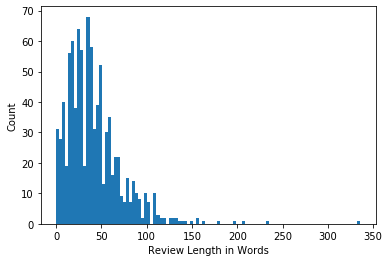

In [34]:
plt.hist(numWords, 100)
plt.xlabel('Review Length in Words')
plt.ylabel('Count')
plt.show()

In [35]:
print('Всего отзывов: ', len(numWords))
print('Всего слов: ', sum(numWords))
print('Всего уникальных слов: ', len(vocabulary))
print('Средняя длина отзыва в словах: ', sum(numWords)/len(numWords))

Всего отзывов:  922
Всего слов:  38550
Всего уникальных слов:  2006
Средняя длина отзыва в словах:  41.81127982646421


In [36]:
df_lem['lemmas'] = lemmatized_texts
df_lem

,comment,date,image,is_fake,lemmas
0,сегодня забирать на почта качество ...,25 ноя 2017 в 6:46,True,1,"[сегодня, , забирать, , на, , почта, , ка..."
1,вчера получать до сей пора не нар...,27 ноя 2017 в 16:20,True,1,"[вчера, , получать, , до, , сей, , пора, ..."
2,спасибо большой все отличный очень ...,28 ноя 2017 в 14:07,True,1,"[спасибо, , большой, , все, , отличный, ,..."
3,спасибо за офигенный кросс \n,1 дек 2017 в 20:55,True,1,"[спасибо, , за, , офигенный, , кросс, \n]"
4,все получать переживать за качество ...,2 дек 2017 в 17:22,True,1,"[все, , получать, , переживать, , за, , к..."
...,...,...,...,...,...
968,приходить штаны никакой повреждение ...,28 мар 2020 в 14:18,True,0,"[приходить, , штаны, , никакой, , поврежде..."
969,ясно спасибо за информация \n,8 ноя 2019 в 16:12,False,0,"[ясно, , спасибо, , за, , информация, \n]"
970,заказывать свитшот спасибо огромны...,19 мар 2018 в 11:09,True,0,"[заказывать, , свитшот, , спасибо, , ..."
971,,22 июн 2018 в 12:07,False,0,[]


In [37]:
# удалим пустые леммы

clean_lemmas = []
regex = re.compile(r'\s+')

for text in lemmatized_texts:
    clean_lemmas.append([i for i in text if not regex.search(i)])

df_lem['lemmas'] = clean_lemmas

In [38]:
# делаем стемминг лемм

stemmer = SnowballStemmer("russian", ignore_stopwords=True)
stems = []

for i in df_lem.lemmas:
    row = []
    for n in i:
        row.append(stemmer.stem(n))
    stems.append(row)    

In [39]:
df_lem['stem'] = stems
df_lem.head(3)

,comment,date,image,is_fake,lemmas,stem
0,сегодня забирать на почта качество ...,25 ноя 2017 в 6:46,True,1,"[сегодня, забирать, на, почта, качество, отлич...","[сегодн, забира, на, почт, качеств, отличн, уп..."
1,вчера получать до сей пора не нар...,27 ноя 2017 в 16:20,True,1,"[вчера, получать, до, сей, пора, не, нарадоват...","[вчер, получа, до, се, пор, не, нарадова, и, п..."
2,спасибо большой все отличный очень ...,28 ноя 2017 в 14:07,True,1,"[спасибо, большой, все, отличный, очень, нрави...","[спасиб, больш, все, отличн, очен, нрав]"


In [40]:
# узнаем число уникальных стемм

vocabulary_stem = list(itertools.chain.from_iterable([i for i in df_lem['stem']]))
len(set(vocabulary_stem))

1817

In [41]:
df_lem.to_csv('out_bow.csv', encoding='utf-8-sig')

# Мешок слов

In [42]:
df_end = df_lem.stem

stem_str = []
for i in df_end:
    stem_str.append(' '.join(i))

In [43]:
stem_str[:2]

['сегодн забира на почт качеств отличн упаковыва все аккуратн размер соответствова на ног сидет хорошо спасиб больш отличн сервис да еще и цен не заламыва быть заказыва еще',
 'вчер получа до се пор не нарадова и про отз забыва спасиб']

In [44]:
df_end = df_lem.copy()
df_end['stem_str'] = stem_str

In [45]:
stop_words = set(stopwords.words("russian"))

bow_transformer = CountVectorizer(stop_words=stop_words ).fit(df_end.stem_str)

In [46]:
# создадим список лемм фейковых отзывов
lemmsFake = list(itertools.chain.from_iterable([i for i in df_lem.lemmas[df.is_fake == 1]]))

# создадим список лемм реальных отзывов
lemmsReal = list(itertools.chain.from_iterable([i for i in df_lem.lemmas[df.is_fake == 0]]))

In [47]:
reviews_bow = bow_transformer.transform(df_end.stem_str)
real_bow = bow_transformer.transform(lemmsReal)
fake_bow = bow_transformer.transform(lemmsFake)

density = (100.0 * reviews_bow.nnz / (reviews_bow.shape[0] * reviews_bow.shape[1]))
print('Density: {}'.format((density)))

Density: 0.7789970652035217


In [48]:
sum_all_words = reviews_bow.sum(axis=0)
sum_real_words = real_bow.sum(axis=0)
sum_fake_words = fake_bow.sum(axis=0)

In [49]:
words_fake_freq = [(word, sum_fake_words[0, idx]) for word, idx in bow_transformer.vocabulary_.items()]
words_fake_freq = sorted(words_fake_freq, key = lambda x: x[1], reverse=True)

In [50]:
words_real_freq = [(word, sum_real_words[0, idx]) for word, idx in bow_transformer.vocabulary_.items()]
words_real_freq = sorted(words_real_freq, key = lambda x: x[1], reverse=True)

In [51]:
words_all_freq = [(word, sum_all_words[0, idx]) for word, idx in bow_transformer.vocabulary_.items()]
words_all_freq = sorted(words_all_freq, key = lambda x: x[1], reverse=True)

### Топ 10 слов

In [52]:
# для фэйковых отзывов

words_fake_freq[:10]

[('спасибо', 281),
 ('размер', 86),
 ('заказ', 78),
 ('магазин', 61),
 ('ваш', 40),
 ('супер', 38),
 ('продавец', 36),
 ('телефон', 33),
 ('менеджер', 24),
 ('цвет', 23)]

In [53]:
# для реальных отзывов

words_real_freq[:10]

[('спасибо', 242),
 ('виктор', 153),
 ('размер', 133),
 ('подарок', 97),
 ('магазин', 89),
 ('носок', 85),
 ('кроссовок', 67),
 ('продавец', 67),
 ('вопрос', 60),
 ('носочек', 53)]

Вхождение в топ слова "Виктор" объясняется тем, что это имена владельца одного из крупных рассмотренных пабликов. Многие пользователи благодарят его в своих отзывах.

In [54]:
# для все отзывов

words_all_freq[:10]

[('заказыва', 544),
 ('спасиб', 523),
 ('качеств', 443),
 ('очен', 374),
 ('приход', 289),
 ('размер', 219),
 ('отличн', 182),
 ('довольн', 181),
 ('хорош', 179),
 ('ве', 173)]

Общих лемм в топах реальных и фальшивых комментариев:

In [55]:
common_items = list((Counter(list(list(zip(*words_real_freq[:100]))[0])) & 
                     (Counter(list(list(zip(*words_fake_freq[:100]))[0])))))
len(common_items)

49

# TF-IDF

In [142]:
word_vectorizer = TfidfVectorizer(max_features=250000,  
                                  stop_words=stop_words,
                                  analyzer='word',
                                  ngram_range=(1,2))

TFIDF = word_vectorizer.fit_transform(stem_str)

# ОБУЧЕНИЕ МОДЕЛЕЙ

In [143]:
# шаблон вывода оценок качества модели

def results(y_test, pred):
    print('accuracy_score: {}'.format(round(accuracy_score(y_test, pred), 3)))    
    print('f1_score: {}'.format(round(f1_score(y_test, pred), 3)))    
    print('roc_auc_score: {}'.format(round(roc_auc_score(y_test, pred), 3)))
    print('confusion_matrix: \n{}'.format(confusion_matrix(y_test, pred)))

## Для Bag of Words

In [144]:
y = df_lem.is_fake

In [145]:
# cоздание тестовой и тренировочной выборок

x = reviews_bow

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=21)

# Logistic regression

#### Начальный результат

In [146]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
pred = logreg.predict(x_test)

results(y_test, pred)

accuracy_score: 0.87
f1_score: 0.87
roc_auc_score: 0.87
confusion_matrix: 
[[121  17]
 [ 19 120]]


#### Подбор параметров

In [147]:
parameters = {'C': [.1, 1, 5, 10, 15, 50, 100],
              'penalty': ['l1', 'l2'],
              'class_weight': ['balanced', {1: 0.7, 0: 0.3}]}

clf = LogisticRegression(random_state=21)
gridSearchCV = GridSearchCV(clf, parameters, scoring='roc_auc')
gridSearchCV.fit(x_train, y_train)

gridSearchCV.best_params_

{'C': 1, 'class_weight': {1: 0.7, 0: 0.3}, 'penalty': 'l2'}

#### Конечный результат

In [148]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
pred = logreg.predict(x_test)

results(y_test, pred)

accuracy_score: 0.87
f1_score: 0.87
roc_auc_score: 0.87
confusion_matrix: 
[[121  17]
 [ 19 120]]


# Bernoulli Naive Bayes

#### Начальный результат

In [149]:
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
pred = bnb.predict(x_test)

results(y_test, pred)

accuracy_score: 0.881
f1_score: 0.885
roc_auc_score: 0.881
confusion_matrix: 
[[117  21]
 [ 12 127]]


#### Подбор параметров

In [150]:
parameters = {"alpha": np.linspace(0.001, 1, 100)}

clf = BernoulliNB()
gridSearchCV = GridSearchCV(clf, parameters, scoring='roc_auc')
gridSearchCV.fit(x_train, y_train)

gridSearchCV.best_params_

{'alpha': 0.334}

#### Конечный результат

In [151]:
bnb = BernoulliNB(alpha=0.334)
bnb.fit(x_train, y_train)
pred = bnb.predict(x_test)

results(y_test, pred)

accuracy_score: 0.892
f1_score: 0.896
roc_auc_score: 0.892
confusion_matrix: 
[[118  20]
 [ 10 129]]


# k-nearest neighbors

#### Начальный результат

In [152]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
pred = knn.predict(x_test)

results(y_test, pred)

accuracy_score: 0.657
f1_score: 0.578
roc_auc_score: 0.658
confusion_matrix: 
[[117  21]
 [ 74  65]]


#### Подбор параметров

In [155]:
parameters = {"n_neighbors": [i for i in range(1, 10)]}

clf = KNeighborsClassifier()
gridSearchCV = GridSearchCV(clf, parameters, scoring='roc_auc')
gridSearchCV.fit(x_train, y_train)

gridSearchCV.best_params_

{'n_neighbors': 8}

#### Конечный результат

In [156]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(x_train, y_train)
pred = knn.predict(x_test)

results(y_test, pred)

accuracy_score: 0.585
f1_score: 0.378
roc_auc_score: 0.586
confusion_matrix: 
[[127  11]
 [104  35]]


# Random Forest

#### Начальный результат

In [157]:
rfclf = RandomForestClassifier()
rfclf.fit(x_train, y_train)
pred = rfclf.predict(x_test)

results(y_test, pred)

accuracy_score: 0.83
f1_score: 0.81
roc_auc_score: 0.831
confusion_matrix: 
[[130   8]
 [ 39 100]]


#### Подбор параметров

In [158]:
random_state=21# Select best RandomForest model with cross validation
possibleRandomForestParameters = [{
        'n_estimators': [10, 25, 50, 100],
        'max_depth': [5, 10, 50, 100, 250, 500, 1000],
        'criterion': ['gini', 'entropy']}]

randomForestModel = RandomForestClassifier(random_state=41)

gridSearchCV = GridSearchCV(estimator=randomForestModel,
                            param_grid=possibleRandomForestParameters,
                            scoring='roc_auc')
gridSearchCV.fit(x_train, y_train)

gridSearchCV.best_params_

{'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 100}

#### Конечный результат

In [159]:
rfclf = RandomForestClassifier(criterion='entropy', max_depth=50,
                               n_estimators=100)
rfclf.fit(x_train, y_train)
pred = rfclf.predict(x_test)

results(y_test, pred)

accuracy_score: 0.856
f1_score: 0.848
roc_auc_score: 0.856
confusion_matrix: 
[[125  13]
 [ 27 112]]


# Gradient Boosting

#### Начальный результат

In [160]:
gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)
pred = gb.predict(x_test)

results(y_test, pred)

accuracy_score: 0.838
f1_score: 0.831
roc_auc_score: 0.838
confusion_matrix: 
[[121  17]
 [ 28 111]]


#### Подбор параметров

In [161]:
param = {'n_estimators': range(2, 50, 2),
         'max_depth': range(3, 20, 2)}
gsearch1 = GridSearchCV(estimator=GradientBoostingClassifier(random_state=21),
                       param_grid=param,
                       scoring='roc_auc')
gsearch1.fit(x_train, y_train)

gsearch1.best_params_

{'max_depth': 5, 'n_estimators': 48}

In [162]:
param = {'min_samples_split': range(100, 801, 200),
         'min_samples_leaf': range(60, 101, 10)}
gsearch2 = GridSearchCV(estimator=GradientBoostingClassifier(random_state=21),
                       param_grid=param,
                       scoring='roc_auc')
gsearch2.fit(x_train, y_train)

gsearch2.best_params_

{'min_samples_leaf': 60, 'min_samples_split': 300}

#### Конечный результат

In [164]:
gb = GradientBoostingClassifier(n_estimators=48, max_depth=5,
                                min_samples_split=300, min_samples_leaf=60)
gb.fit(x_train, y_train)
pred = gb.predict(x_test)

results(y_test, pred)

accuracy_score: 0.765
f1_score: 0.79
roc_auc_score: 0.765
confusion_matrix: 
[[ 90  48]
 [ 17 122]]


# Метод опорных векторов

In [165]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#### Начальный результат

In [166]:
SVC = make_pipeline(StandardScaler(with_mean=False), SVC(random_state=21))
SVC.fit(x_train, y_train)
pred = SVC.predict(x_test)

results(y_test, pred)

accuracy_score: 0.791
f1_score: 0.758
roc_auc_score: 0.791
confusion_matrix: 
[[128  10]
 [ 48  91]]


#### Подбор параметров

In [170]:
param_grid_pipeline = {'svc__C': 10. ** np.arange(-3, 3),
                       'svc__gamma': 10. ** np.arange(-3, 3)}

scaler_pipe = make_pipeline(StandardScaler(with_mean=False), SVC())
grid = GridSearchCV(scaler_pipe, param_grid=param_grid_pipeline, cv=5)
grid.fit(x_train, y_train)

print(grid.best_params_)

{'svc__C': 10.0, 'svc__gamma': 0.001}


#### Конечный результат

In [171]:
SVC = make_pipeline(StandardScaler(with_mean=False), SVC(C=10.0, gamma=0.001))
SVC.fit(x_train, y_train)
pred = SVC.predict(x_test)

results(y_test, pred)

accuracy_score: 0.769
f1_score: 0.756
roc_auc_score: 0.769
confusion_matrix: 
[[114  24]
 [ 40  99]]


## Для TF-IDF

In [172]:
# cоздание тестовой и тренировочной выборок

x = stem_str

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(TFIDF, y, test_size=0.30, random_state=21)

# Logistic regression

#### Начальный результат

In [173]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
pred = logreg.predict(x_test)

results(y_test, pred)

accuracy_score: 0.856
f1_score: 0.86
roc_auc_score: 0.855
confusion_matrix: 
[[114  24]
 [ 16 123]]


#### Подбор параметров

In [174]:
parameters = {'C': [.1, 1, 5, 10, 15, 50, 100],
              'penalty': ['l1', 'l2'],
              'class_weight': ['balanced', {1: 0.7, 0: 0.3}]}

clf = LogisticRegression()
gridSearchCV = GridSearchCV(clf, parameters, scoring='roc_auc')
gridSearchCV.fit(x_train, y_train)

gridSearchCV.best_params_

{'C': 100, 'class_weight': 'balanced', 'penalty': 'l2'}

#### Конечный результат

In [175]:
logreg = LogisticRegression(C=100)
logreg.fit(x_train, y_train)
pred = logreg.predict(x_test)

results(y_test, pred)

accuracy_score: 0.856
f1_score: 0.852
roc_auc_score: 0.856
confusion_matrix: 
[[122  16]
 [ 24 115]]


# Bernoulli Naive Bayes

#### Начальный результат

In [176]:
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
pred = bnb.predict(x_test)

results(y_test, pred)

accuracy_score: 0.848
f1_score: 0.843
roc_auc_score: 0.849
confusion_matrix: 
[[122  16]
 [ 26 113]]


#### Подбор параметров

In [177]:
parameters = {"alpha": np.linspace(0.001, 1, 100)}

clf = BernoulliNB()
gridSearchCV = GridSearchCV(clf, parameters, scoring='roc_auc')
gridSearchCV.fit(x_train, y_train)

gridSearchCV.best_params_

{'alpha': 0.8385454545454546}

#### Конечный результат

In [178]:
bnb = BernoulliNB(alpha=0.838)
bnb.fit(x_train, y_train)
pred = bnb.predict(x_test)

results(y_test, pred)

accuracy_score: 0.859
f1_score: 0.86
roc_auc_score: 0.859
confusion_matrix: 
[[118  20]
 [ 19 120]]


# k-nearest neighbors

#### Начальный результат

In [179]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
pred = knn.predict(x_test)

results(y_test, pred)

accuracy_score: 0.505
f1_score: 0.402
roc_auc_score: 0.506
confusion_matrix: 
[[94 44]
 [93 46]]


#### Подбор параметров

In [180]:
parameters = {"n_neighbors": [i for i in range(1, 8)]}

clf = KNeighborsClassifier()
gridSearchCV = GridSearchCV(clf, parameters, scoring='roc_auc')
gridSearchCV.fit(x_train, y_train)

gridSearchCV.best_params_

{'n_neighbors': 2}

#### Конечный результат

In [181]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)
pred = knn.predict(x_test)

results(y_test, pred)

accuracy_score: 0.606
f1_score: 0.355
roc_auc_score: 0.608
confusion_matrix: 
[[138   0]
 [109  30]]


# Random Forest

#### Начальный результат

In [182]:
rfclf = RandomForestClassifier()
rfclf.fit(x_train, y_train)
pred = rfclf.predict(x_test)

results(y_test, pred)

accuracy_score: 0.816
f1_score: 0.812
roc_auc_score: 0.816
confusion_matrix: 
[[116  22]
 [ 29 110]]


#### Подбор параметров

In [183]:
# Select best RandomForest model with cross validation
possibleRandomForestParameters = [{
        'n_estimators': [10, 25, 50, 100],
        'max_depth': [5, 10, 50, 100, 250, 500, 1000],
        'criterion': ['gini', 'entropy']}]

randomForestModel = RandomForestClassifier()

gridSearchCV = GridSearchCV(estimator=randomForestModel,
                            param_grid=possibleRandomForestParameters,
                            scoring='roc_auc')
gridSearchCV.fit(x_train, y_train)

gridSearchCV.best_params_

{'criterion': 'entropy', 'max_depth': 250, 'n_estimators': 100}

#### Конечный результат

In [184]:
rfclf = RandomForestClassifier(criterion='entropy', max_depth=100, n_estimators=50)
rfclf.fit(x_train, y_train)
pred = rfclf.predict(x_test)

results(y_test, pred)

accuracy_score: 0.859
f1_score: 0.855
roc_auc_score: 0.859
confusion_matrix: 
[[123  15]
 [ 24 115]]


# Gradient Boosting

#### Начальный результат

In [186]:
gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)
pred = gb.predict(x_test)

results(y_test, pred)

accuracy_score: 0.823
f1_score: 0.834
roc_auc_score: 0.823
confusion_matrix: 
[[105  33]
 [ 16 123]]


#### Подбор параметров

In [187]:
param = {'n_estimators': range(2, 50, 2),
         'max_depth': range(3, 20, 2)}
gsearch1 = GridSearchCV(estimator=GradientBoostingClassifier(),
                       param_grid=param,
                       scoring='roc_auc')
gsearch1.fit(x_train, y_train)

gsearch1.best_params_

{'max_depth': 9, 'n_estimators': 46}

In [188]:
param = {'min_samples_split': range(100, 801, 200),
         'min_samples_leaf': range(60, 101, 10)}
gsearch2 = GridSearchCV(estimator=GradientBoostingClassifier(),
                       param_grid=param,
                       scoring='roc_auc')
gsearch2.fit(x_train, y_train)

gsearch2.best_params_

{'min_samples_leaf': 60, 'min_samples_split': 300}

#### Конечный результат

In [190]:
gb = GradientBoostingClassifier(n_estimators=46, max_depth=9,
                                min_samples_split=300, min_samples_leaf=60)
gb.fit(x_train, y_train)
pred = gb.predict(x_test)

results(y_test, pred)

accuracy_score: 0.773
f1_score: 0.789
roc_auc_score: 0.772
confusion_matrix: 
[[ 96  42]
 [ 21 118]]


# Метод опорных векторов

In [197]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#### Начальный результат

In [195]:
SVC = make_pipeline(StandardScaler(with_mean=False), SVC())
SVC.fit(x_train, y_train)
pred = SVC.predict(x_test)

results(y_test, pred)

accuracy_score: 0.639
f1_score: 0.451
roc_auc_score: 0.64
confusion_matrix: 
[[136   2]
 [ 98  41]]


#### Подбор параметров

In [198]:
param_grid_pipeline = {'svc__C': 10. ** np.arange(-3, 3),
                       'svc__gamma': 10. ** np.arange(-3, 3)}

scaler_pipe = make_pipeline(StandardScaler(with_mean=False), SVC())
grid = GridSearchCV(scaler_pipe, param_grid=param_grid_pipeline,
                    cv=5, scoring='roc_auc')
grid.fit(x_train, y_train)

print(grid.best_params_)

{'svc__C': 100.0, 'svc__gamma': 0.001}


#### Конечный результат

In [199]:
SVC = make_pipeline(StandardScaler(with_mean=False),
                    SVC(C=100.0, gamma=0.001))
SVC.fit(x_train, y_train)
pred = SVC.predict(x_test)

results(y_test, pred)

accuracy_score: 0.606
f1_score: 0.355
roc_auc_score: 0.608
confusion_matrix: 
[[138   0]
 [109  30]]
